In [1]:
%pylab inline
import pickle
import numpy as np
import os
import DifferentiableHOS as DHOS
import tensorflow as tf
from scipy import ndimage, misc
from DifferentiableHOS.Fisher import fisher

In [2]:
field_size=5.
field_npix=1004
pix_scale = 5/1004*60# arcmin
sigma_pix=1/pix_scale

In [118]:
# Load maps 
kmaps = []
for filename in os.listdir("/global/cscratch1/sd/dlan/maps/maps"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/maps/maps', filename), 'rb'))
        kmaps.append(res['kmap'])

In [119]:
for filename in os.listdir("/global/cscratch1/sd/dlan/maps/maps2"):
        res2 =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/maps/maps2', filename), 'rb'))
        kmaps.append(res2['kmap'])

In [120]:
def rebin(a, shape):
    sh = shape, a.shape[0] // shape
    return tf.math.reduce_mean(tf.reshape(a, sh), axis=-1)
def perf_smoothing(kmap):
    kmap= numpy.fft.fft2(kmap)
    kmap =ndimage.fourier_gaussian(kmap, sigma=sigma_pix)
    kmap=numpy.fft.ifft2(kmap)
    kmap=kmap.real
    return kmap
def desc_y1_analysis(kmap):
    """
  Adds noise and apply smoothing we might expect in DESC Y1 SRD setting
  """
    ngal = 10  # gal/arcmin **2
    pix_scale = field_size / field_npix * 60  # arcmin
    ngal_per_pix = ngal * pix_scale**2  # galaxies per pixels
    sigma_e = 0.26 / np.sqrt(2 * ngal_per_pix)  # Rescaled noise sigma
    sigma_pix = 1. / pix_scale  # Smooth at 1 arcmin
    # Add noise
    kmap = kmap + sigma_e * tf.random.normal(kmap.shape)
    # Add smoothing
    kmap = perf_smoothing(kmap)
    return kmap

In [121]:
kmaps_r=[]
for m in kmaps:
        m=desc_y1_analysis(m)
        kmaps_r.append(m)
        

In [129]:
#ps_tot=[]
pcounts_tot=[]
for m in kmaps_r:
    #ell, power_spectrum = DHOS.statistics.power_spectrum(m[0], field_size,field_npix)
    # Keep only ell between 300 and 3000
    #ell = ell[2:46]
    #power_spectrum = power_spectrum[2:46]
    # Further reducing the nnumber of points
    #ell = rebin(ell, 11)
    #power_spectrum = rebin(power_spectrum, 11)
    #ps_tot.append(power_spectrum)
    counts, bins = DHOS.statistics.peaks_histogram_tf(
            np.float32(m[0]), tf.linspace(-0.029, 0.09, 8))
    pcounts_tot.append(counts)


In [9]:
ps_tot= stack(ps_tot, axis=0)

In [131]:
pcounts_tot=stack(pcounts_tot, axis=0)

In [133]:
#np.save("ps.npy",ps_tot)
#np.save("pcounts.npy",pcounts_tot)

In [3]:
ps_tot=np.load("ps.npy")

In [ ]:
loglog(ell,ell*(ell+1)*ps_tot.mean(axis=0)/(2*np.pi),label='all')
loglog(ell,ell*(ell+1)*ps_tot[:1000].mean(axis=0)/(2*np.pi),label='1000')
loglog(ell,ell*(ell+1)*ps_tot[:800].mean(axis=0)/(2*np.pi),label='800')
loglog(ell,ell*(ell+1)*ps_tot[:600].mean(axis=0)/(2*np.pi),label='600')
loglog(ell,ell*(ell+1)*ps_tot[:120].mean(axis=0)/(2*np.pi),label='120')
loglog(ell,ell*(ell+1)*ps_tot[:100].mean(axis=0)/(2*np.pi),label='100')
loglog(ell,ell*(ell+1)*ps_tot[:110].mean(axis=0)/(2*np.pi),label='110')
loglog(ell,ell*(ell+1)*ps_tot[:90].mean(axis=0)/(2*np.pi),label='90')
loglog(ell,ell*(ell+1)*ps_tot[:70].mean(axis=0)/(2*np.pi),label='70')

legend()

In [5]:
import math
fov_rad=math.radians(5)
Omega_sky=pi*(fov_rad)**2#Omega_sky is defined as pi for my field ov view squared translated in radians
f_sky=Omega_sky/4/pi


In [136]:
cov_ps=np.cov(ps_tot, rowvar=False)*f_sky/0.25
cov_pcounts=np.cov(pcounts_tot, rowvar=False)*f_sky/0.25

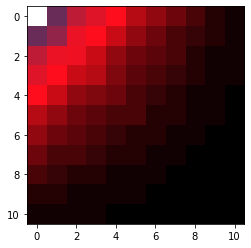

In [7]:
imshow(cov_ps,cmap='gist_stern')

In [8]:
#Now, loading the jacobians of the power spectrum computed for more parameters 
ps_jac_corner= []
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_ps/jac2"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_ps/jac2', filename), 'rb'))
        ps_jac_corner.append(res['jac_ps'])

In [9]:
#Now, loading the jacobians of the power spectrum computed for more parameters 
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_ps/jac3"):
        res2 =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_ps/jac3', filename), 'rb'))
        ps_jac_corner.append(res2['jac_ps'])

In [10]:
#Now, loading the jacobians of the power spectrum computed for more parameters 
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_ps/jac4"):
        res3 =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_ps/jac4', filename), 'rb'))
        ps_jac_corner.append(res3['jac_ps'])

In [11]:
ps_jac_corner = stack(ps_jac_corner, axis=0)

In [13]:
labels=["$\Omega_c$","$\sigma8$","$\Omega_b$","$n_s$","$h$","$w_0$"]

In [14]:
# The way to use this:
fid_cosmo = {"$\Omega_c$": 0.2589,
             "$\sigma8$": 0.8159,
             "$\Omega_b$": 0.04860,
             "$n_s$": 0.9667,
             "$h$": 0.6774,
             "$w_0$": -1.0}

In [221]:
dmu_ps = ps_jac_corner.mean(axis=0)
Fisher_ps=dmu_ps.T @ (np.linalg.inv(cov_ps)) @ dmu_ps
fisher_object_ps = fisher(Fisher_ps, labels,  fid_cosmo)

In [222]:
dmu_ps_230 = ps_jac_corner[:230].mean(axis=0)
Fisher_ps_230=dmu_ps_230.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_230
fisher_object_ps_230 = fisher(Fisher_ps_230, labels,  fid_cosmo)

In [223]:
dmu_ps_210 = ps_jac_corner[:210].mean(axis=0)
Fisher_ps_210=dmu_ps_210.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_210
fisher_object_ps_210 = fisher(Fisher_ps_210, labels,  fid_cosmo)

In [224]:
dmu_ps_190 = ps_jac_corner[:190].mean(axis=0)
Fisher_ps_190=dmu_ps_190.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_190
fisher_object_ps_190 = fisher(Fisher_ps_190, labels,  fid_cosmo)

In [225]:
dmu_ps_170 = ps_jac_corner[:170].mean(axis=0)
Fisher_ps_170=dmu_ps_170.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_170
fisher_object_ps_170 = fisher(Fisher_ps_170, labels,  fid_cosmo)

In [226]:
dmu_ps_150 = ps_jac_corner[:150].mean(axis=0)
Fisher_ps_150=dmu_ps_150.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_150
fisher_object_ps_150 = fisher(Fisher_ps_150, labels,  fid_cosmo)

In [227]:
dmu_ps_130 = ps_jac_corner[:130].mean(axis=0)
Fisher_ps_130=dmu_ps_130.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_130
fisher_object_ps_130 = fisher(Fisher_ps_130, labels,  fid_cosmo)

In [228]:
dmu_ps_110 = ps_jac_corner[:110].mean(axis=0)
Fisher_ps_110=dmu_ps_110.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_110
fisher_object_ps_110 = fisher(Fisher_ps_110, labels,  fid_cosmo)

In [229]:
dmu_ps_90 = ps_jac_corner[:90].mean(axis=0)
Fisher_ps_90=dmu_ps_90.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_90
fisher_object_ps_90 = fisher(Fisher_ps_90, labels,  fid_cosmo)

In [230]:
dmu_ps_70 = ps_jac_corner[:70].mean(axis=0)
Fisher_ps_70=dmu_ps_70.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_70
fisher_object_ps_70 = fisher(Fisher_ps_70, labels,  fid_cosmo)

In [231]:
fac=np.sqrt(np.diag(cov_ps))

In [232]:
k=np.arange(11)
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

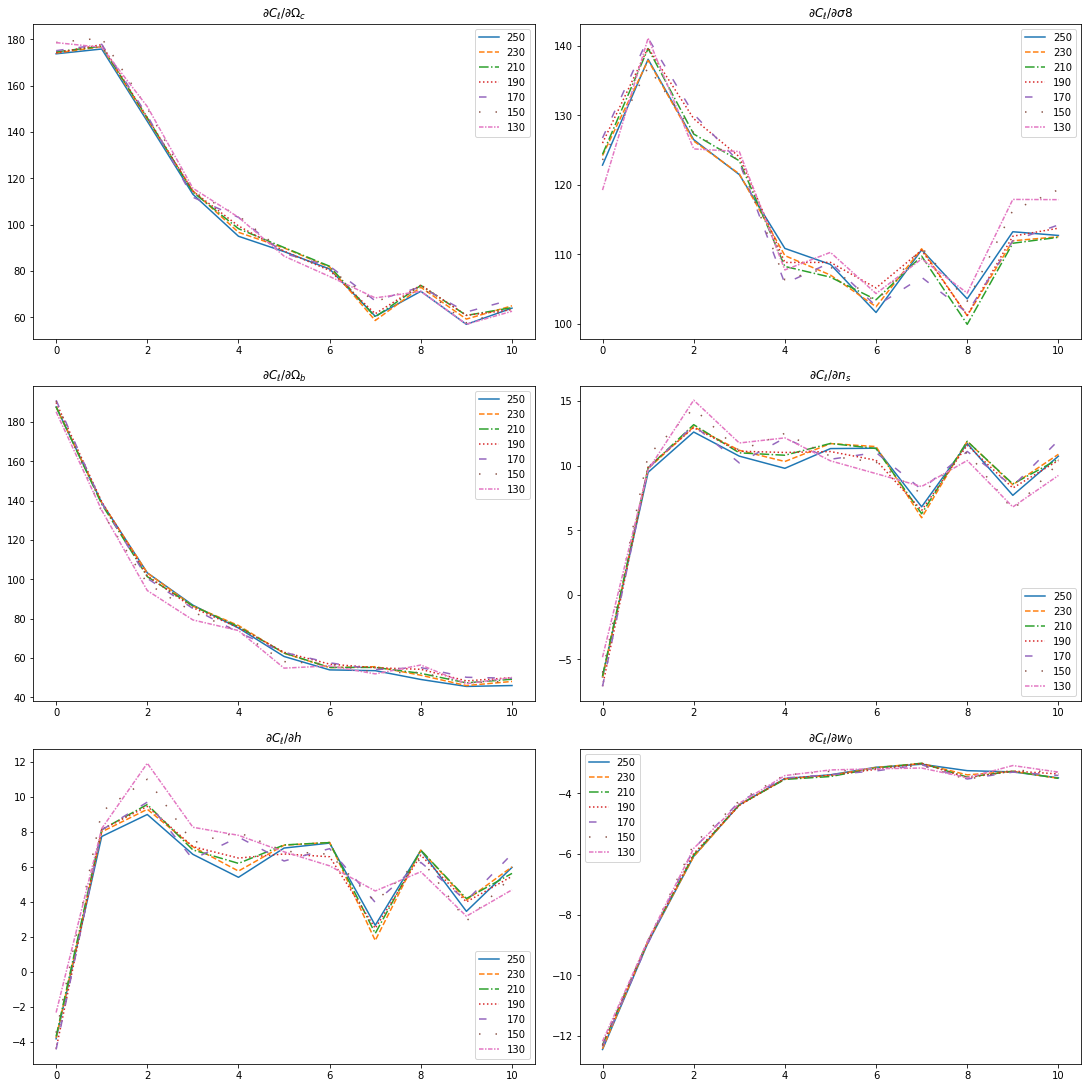

In [235]:
figsize = (15, 15)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 2
rows =3
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(dmu_ps[0]))
for ax, i in zip(axs, range(6)):
    ax.plot(k,dmu_ps[...,i]/fac,label='250')
    ax.plot(k,dmu_ps_230[...,i]/fac,label='230',linestyle='dashed')
    ax.plot(k,dmu_ps_210[...,i]/fac,label='210',linestyle='dashdot')
    ax.plot(k,dmu_ps_190[...,i]/fac,label='190',linestyle='dotted')
    ax.plot(k,dmu_ps_170[...,i]/fac,label='170',linestyle= (0, (5, 10)))
    ax.plot(k,dmu_ps_150[...,i]/fac,label='150',linestyle=(0, (1, 10)))
    ax.plot(k,dmu_ps_130[...,i]/fac,label='130',linestyle=(0, (3, 1, 1, 1)))
    ax.set_title('$\partial C_\ell/\partial$' +str(labels[i]))
    ax.legend()


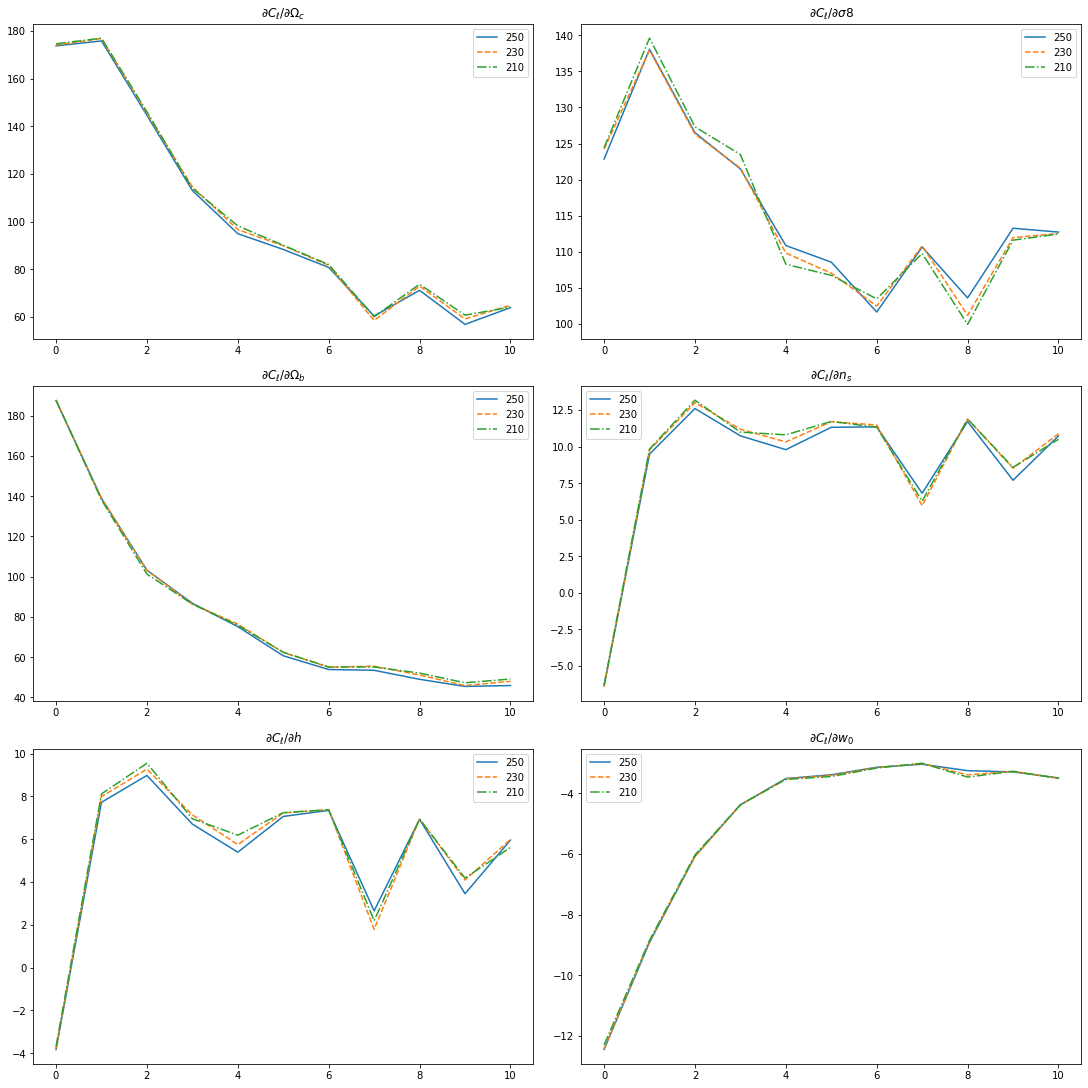

In [272]:
figsize = (15, 15)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 2
rows =3
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(dmu_ps[0]))
for ax, i in zip(axs, range(6)):
    ax.plot(k,dmu_ps[...,i]/fac,label='250')
    ax.plot(k,dmu_ps_230[...,i]/fac,label='230',linestyle='dashed')
    ax.plot(k,dmu_ps_210[...,i]/fac,label='210',linestyle='dashdot')
    ax.set_title('$\partial C_\ell/\partial$' +str(labels[i]))
    ax.legend()


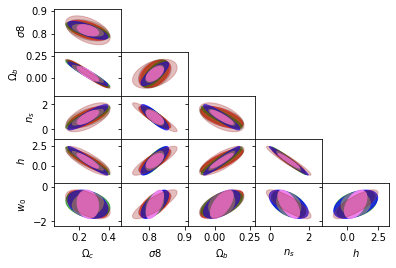

In [249]:
fisher_object_ps_230.corner_plot(color='k',alpha=0.2)
fisher_object_ps_210.corner_plot(color='orange',alpha=0.3)
fisher_object_ps_190.corner_plot(color='green',alpha=0.4)
fisher_object_ps_170.corner_plot(color='red',alpha=0.5)
fisher_object_ps_130.corner_plot(color='green',alpha=0.6)
fisher_object_ps_110.corner_plot(color='blue',alpha=0.7)
fisher_object_ps_90.corner_plot(color='grey',alpha=0.8)
fisher_object_ps_70.corner_plot(color='violet',alpha=1)
fisher_object_ps.corner_plot(color='brown',alpha=0.3)
#savefig("all.png",dpi=150)

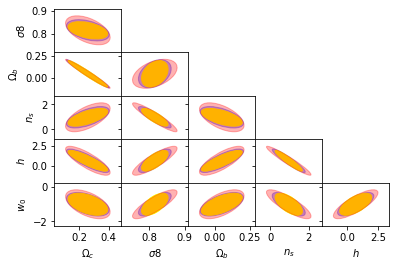

In [244]:
fisher_object_ps_230.corner_plot(color='blue',alpha=0.3)
fisher_object_ps_210.corner_plot(color='yellow',alpha=1)
fisher_object_ps.corner_plot(color='red',alpha=0.3,label='all')

#savefig("last2.png",dpi=150)

In [190]:
#Now, loading the jacobians of the peak counts computed for more parameters 
pcounts_jac_corner= []
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_peak_counts/jac2"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_peak_counts/jac2', filename), 'rb'))
        pcounts_jac_corner.append(res['jac_pc'])

In [191]:
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_peak_counts/jac3"):
        res2 =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_peak_counts/jac3', filename), 'rb'))
        pcounts_jac_corner.append(res2['jac_pc'])

In [261]:
pcounts_jac = stack(pcounts_jac_corner, axis=0)

In [262]:
fac2=np.sqrt(np.diag(cov_pcounts))

In [263]:
dmu_pcounts = pcounts_jac.mean(axis=0)
Fisher_pcounts=dmu_pcounts.T @ (np.linalg.inv(cov_pcounts)) @ dmu_pcounts
fisher_object_pcounts = fisher(Fisher_pcounts, labels,  fid_cosmo)

In [264]:
dmu_pcounts_180 = pcounts_jac[:180].mean(axis=0)
Fisher_pcounts_180=dmu_pcounts_180.T @ (np.linalg.inv(cov_pcounts)) @ dmu_pcounts_180
fisher_object_pcounts_180 = fisher(Fisher_pcounts_180, labels,  fid_cosmo)

In [265]:
dmu_pcounts_160 = pcounts_jac[:160].mean(axis=0)
Fisher_pcounts_160=dmu_pcounts_160.T @ (np.linalg.inv(cov_pcounts)) @ dmu_pcounts_160
fisher_object_pcounts_160 = fisher(Fisher_pcounts_160, labels,  fid_cosmo)

In [266]:
dmu_pcounts_140 = pcounts_jac[:140].mean(axis=0)
Fisher_pcounts_140=dmu_pcounts_140.T @ (np.linalg.inv(cov_pcounts)) @ dmu_pcounts_140
fisher_object_pcounts_140 = fisher(Fisher_pcounts_140, labels,  fid_cosmo)

In [267]:
dmu_pcounts_120 = pcounts_jac[:120].mean(axis=0)
Fisher_pcounts_120=dmu_pcounts_120.T @ (np.linalg.inv(cov_pcounts)) @ dmu_pcounts_120
fisher_object_pcounts_120 = fisher(Fisher_pcounts_120, labels,  fid_cosmo)

In [268]:
dmu_pcounts_100 = pcounts_jac[:100].mean(axis=0)
Fisher_pcounts_100=dmu_pcounts_100.T @ (np.linalg.inv(cov_pcounts)) @ dmu_pcounts_100
fisher_object_pcounts_100 = fisher(Fisher_pcounts_100, labels,  fid_cosmo)

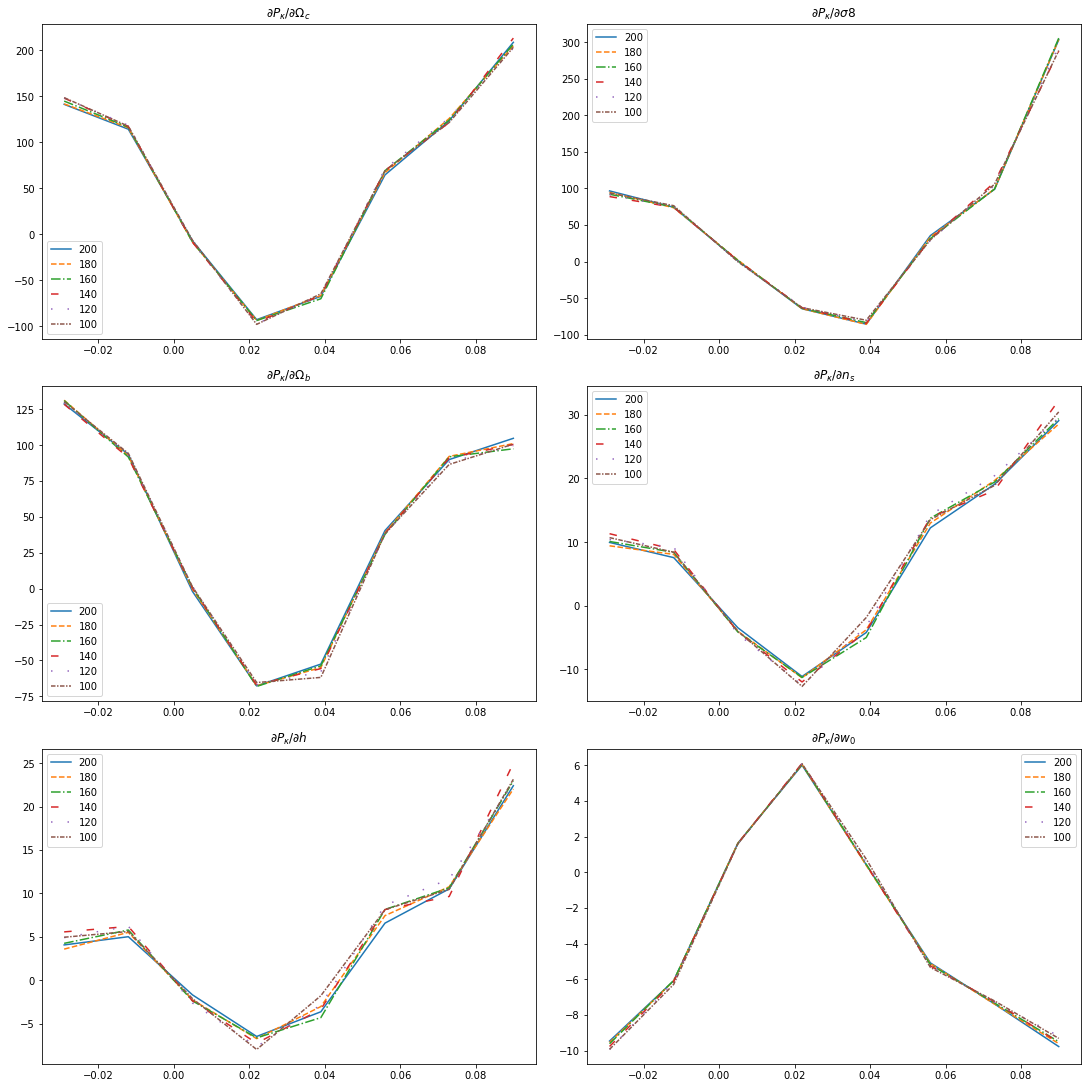

In [269]:
figsize = (15, 15)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 2
rows =3
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(dmu_pcounts[0]))
for ax, i in zip(axs, range(6)):
    ax.plot(bins,dmu_pcounts[...,i]/fac2,label='200')
    ax.plot(bins,dmu_pcounts_180[...,i]/fac2,label='180',linestyle='dashed')
    ax.plot(bins,dmu_pcounts_160[...,i]/fac2,label='160',linestyle='dashdot')
    ax.plot(bins,dmu_pcounts_140[...,i]/fac2,label='140',linestyle= (0, (5, 10)))
    ax.plot(bins,dmu_pcounts_120[...,i]/fac2,label='120',linestyle=(0, (1, 10)))
    ax.plot(bins,dmu_pcounts_100[...,i]/fac2,label='100',linestyle=(0, (3, 1, 1, 1)))
    ax.set_title('$\partial P_\kappa/\partial$' +str(labels[i]))
    ax.legend()


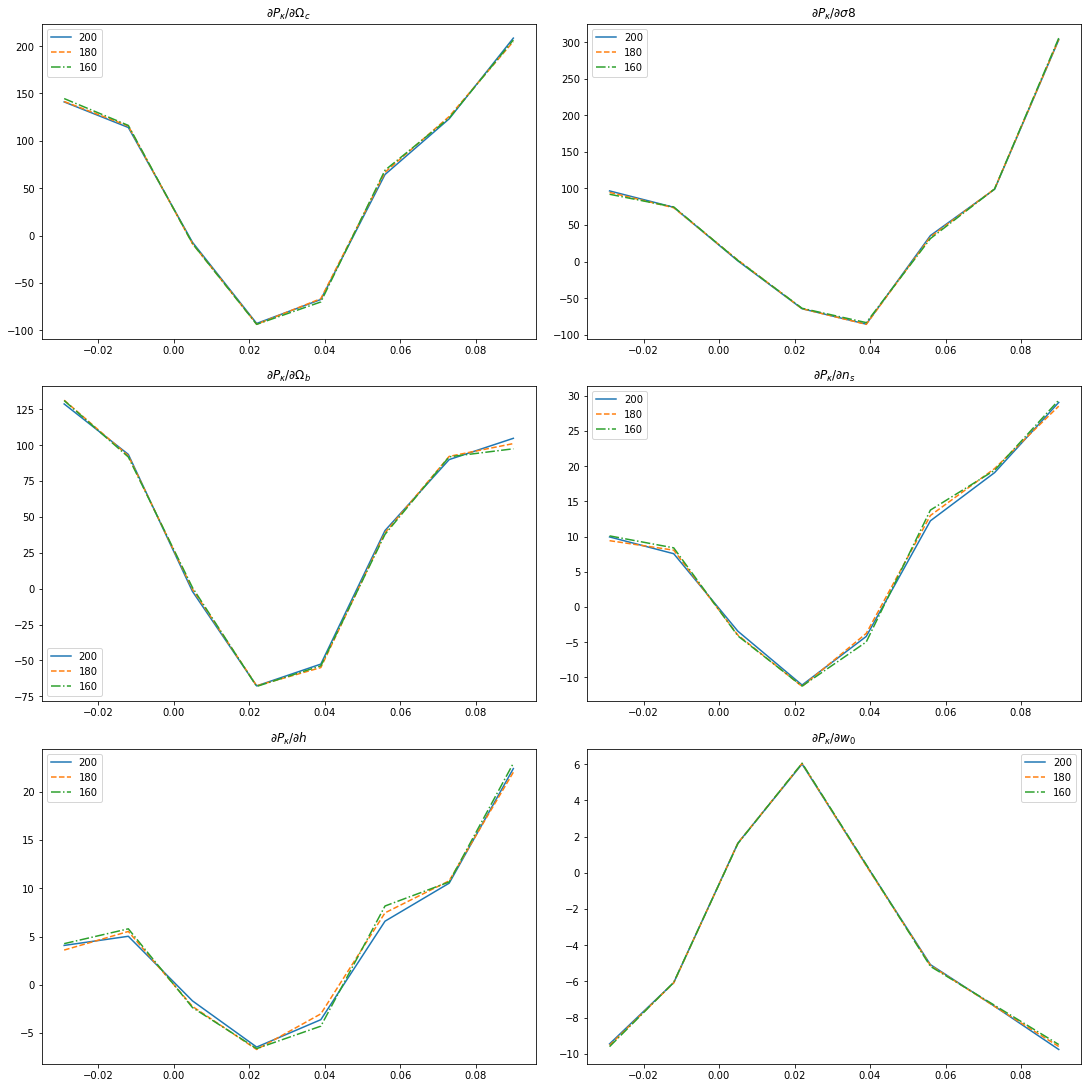

In [271]:
figsize = (15, 15)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 2
rows =3
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(dmu_pcounts[0]))
for ax, i in zip(axs, range(6)):
    ax.plot(bins,dmu_pcounts[...,i]/fac2,label='200')
    ax.plot(bins,dmu_pcounts_180[...,i]/fac2,label='180',linestyle='dashed')
    ax.plot(bins,dmu_pcounts_160[...,i]/fac2,label='160',linestyle='dashdot')
    ax.set_title('$\partial P_\kappa/\partial$' +str(labels[i]))
    ax.legend()


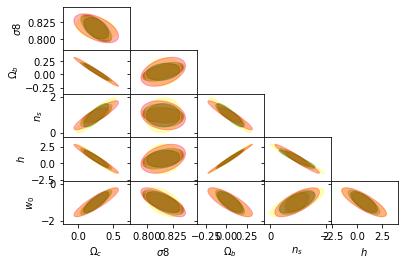

In [260]:

fisher_object_pcounts.corner_plot(color='brown',alpha=0.3)
fisher_object_pcounts_180.corner_plot(color='orange',alpha=1.3)
fisher_object_pcounts_160.corner_plot(color='green',alpha=1.3)
fisher_object_pcounts_120.corner_plot(color='yellow',alpha=1.3)
fisher_object_pcounts_100.corner_plot(color='green',alpha=1.3)
fisher_object_pcounts_140.corner_plot(color='red',alpha=0.3)
#savefig("all.png",dpi=150)

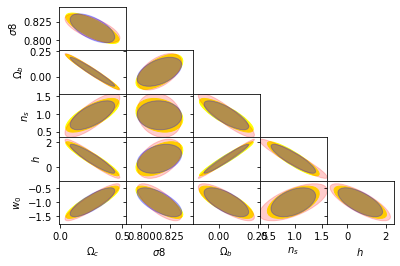

In [258]:
fisher_object_pcounts_180.corner_plot(color='yellow',alpha=1)
fisher_object_pcounts_160.corner_plot(color='red',alpha=0.2)
fisher_object_pcounts.corner_plot(color='blue',alpha=0.3)